# Lithium Ion Battery
In this example, we will illustrate how to calculate the open circuit voltage (voltage when the external applied current is 0) for a lithium ion battery as a function of anode and cathode lithium content.

The thermodynamics are based on a graphite anode and a LiCoO2 cathode (the typical/standard active materials for commercial batteries, as of 2019), and are modeled using the 'BinarySolutionTabulatedThermo' class.

For the sake of simplicity, we're going to assume that the anode and cathode capacities are perfectly balanced (i.e. if the cathode lithium content is X percent of its max possible (i.e. its capacity), then we will assume that the anode is at 1-X percent.  Without loss of generality, we will define the anode composition.

The routine below returns the cell voltage (in Volt) of a lithium-ion cell for a given cell current and active material lithium stoichiometries.

Note that the function 'E_cell' below has even greater capabilities than what we use, here. It calculates the steady state cell voltage, at a given composition and cell current, for a given electrolyte ionic resistance.  This functionality is presented in greater detail in the reference (which also describes the derivation of the BinarySolutionTabulatedThermo class): 

>M. Mayur, S. C. DeCaluwe, B. L. Kee, W. G. Bessler, “Modeling and simulation of the thermodynamics of lithium-ion battery intercalation materials in the open-source software Cantera,” _Electrochim. Acta_ 323, 134797 (2019), https://doi.org/10.1016/j.electacta.2019.134797

In the future, this example may be developed further to demonstrate simulating charge-discharge of the lithium ion battery.


Other than the typical Cantera dependencies, plotting functions require that you have matplotlib installed, and finding the electrode potentials uses Scipy's fsolve. See https://matplotlib.org/ and https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html for additional info.

The open circuit (i.e. equilibrium) voltage, here, is calculated via two means: kinetically and thermodynamically.

The system here, can be thought of as consisting of two particles--anode and cathode--connected by a liquid electrolyte:

<img src="images/SingleParticleBattery.png" alt="Cartoon of a Single Particle Battery Model" style="width: 500px;"/>

### Kinetic equilibrium calculations
In the kinetic equilibrium problem, steady state is achieved when the faradaic current at each electrode (anode and cathode) surface and the ionic current through the electrolyte are all zero.  There are, essentially, four relevant electric potentials which must be determined:

- $\phi_{\rm anode}$: electric potential of graphite anode.
- $\phi_{\rm elyte,\, anode}$: electric potential of electrolyte at anode interface.
- $\phi_{\rm elyte,\, cathode}$: electric potential of electrolyte at cathode interface.
- $\phi_{\rm cathode}$: electric potential of LCO cathode.

Setting one of these four to the reference potential of zero (because it is the difference in electric potential which drives currents, the actual potential values are irrelevant. Let's assume the anode electric potential is zero), there is only one distribution of electric potentials across the cell such that the current is invariant across the cell.  I.e. we want the potentials such that:

\begin{equation}
i_{\rm Far,\, anode} = i_{\rm ionic} = i_{\rm Far,\,cathode}= i_{\rm app}
\end{equation}

where $i_{\rm app}$ is the user input for the applied current.  For this example, we assume an applied current of 0, to calculate the equilibrium voltage.

#### Faradaic current
The Faradaic current for this model is calculated using Butler-Volmer kinetics.  For a Li-ion battery, this is:

\begin{equation}
i = S_{\rm elde}i_\circ\left[\exp\left(\frac{F\beta\eta}{RT}\right) - \exp\left(-\frac{F(1-\beta)\eta}{RT}\right) \right]
\end{equation}

where $S_{\rm elde}$ is the specific surface area of the electrode in question, $F$ is Faraday's constant, $\beta$ is the charge-transfer symmetry parameter, $R$ the universal gas constant, $T$ the temperature, and $\eta$ the overpotential, which is the electric potential difference between the electrode and electrolyte, $\Delta \phi = \phi_{\rm elde} - \phi_{\rm elyte}$, relative to that at equilibrium, $\Delta \phi_{\rm eq}$:

\begin{equation}
\eta = \Delta \phi - \Delta \phi_{\rm eq}
\end{equation}

$i_\circ$ is known as the "exchange current density," which is equal to the rate of the forward and reverse current at equilibrium (which are equal).  $i_\circ$ and $\beta$ are provided as user inputs in the cti file.  At any particular state, (user-specified electric potentials, pressure, temperature, and chemical compositions), Cantera calculates $\eta$ as part of the routine to evaluate reaction rates of progress $\left(\dot{q} = \frac{i_{\rm Far}}{F}\right)$. The user simply sets the state values mentioned above.

#### Ionic current
The electrolyte is modeled as a resistor with user-defined ionic resistance $R_{\rm io}$, and hence the ionic current is calculated as:

\begin{equation}
i_{\rm ionic} = \frac{\phi_{\rm elyte,\,ca} - \phi_{\rm elyte,\,an}}{R_{\rm io}}
\end{equation}

where positive current is defined as delivering Li$^+$ to the anode interface.  Given $i_{\rm app}$, this equation can be inverted, to calculate the electric potential of the electrolyte at the cathode interface, relative to that at the anode interface:

\begin{equation}
\phi_{\rm elyte,\,ca} = \phi_{\rm elyte,\,an} + R_{\rm io}i_{\rm app} 
\end{equation}

Again: in this example, $i_{\rm app} = 0$ and hence the two electric potential values in the electrolyte are equal.

#### Numerical routine
For the kinetic routine, there are three processes to determine the cell voltage $\phi_{\rm cathode} - \phi_{\rm anode}$ which corresponds to the user-provided $i_{\rm app}$:
1. Determine the $\phi_{\rm elyte,\,anode}$ value which corresponds to $i_{\rm app}$, given $X_{\rm Li, anode}$, the percentage of Li in the anode active material.
2. Determine $\phi_{\rm elyte,\,cathode}$, given $\phi_{\rm elyte,\,anode}$ and $i_{\rm app}$.
3. Determine the $\phi_{\rm cathode}$ which corresponds to $i_{\rm app}$, given $\phi_{\rm elyte,\,cathode}$ and $X_{\rm Li, anode}$, the percentage of Li in the anode active material.

The routines below are written generally such that an interested user may set $i_{\rm app}$ to any value of interest.

#### Import necessary packages:

In [1]:
import cantera as ct

print(f"Runnning Cantera version: {ct.__version__}")

Runnning Cantera version: 2.6.0


In [2]:
import numpy as np

from scipy.optimize import fsolve

# Used for timing our calculations:
import time

# Plotting:
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
import matplotlib.pyplot as plt

plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 120

### Define the phases

The phase thermodynamics are defined according to experimentally-measured open circuit voltage values, as desscribed in the reference provided above:

In [3]:
input_file = "../data/lithium_ion_battery.yaml"
anode = ct.Solution(input_file, "anode")
cathode = ct.Solution(input_file, "cathode")
# The 'elde' electrode phase is needed as a source/sink for electrons:
elde = ct.Solution(input_file, "electron")
elyte = ct.Solution(input_file, "electrolyte")
anode_interface = ct.Interface(
    input_file, "edge_anode_electrolyte", [anode, elde, elyte]
)
cathode_interface = ct.Interface(
    input_file, "edge_cathode_electrolyte", [cathode, elde, elyte]
);

### Define battery conditions : temperature, pressure, stoichiometry, electrolyte resistance:

Inputs are:
- Stoichiometries X_Li_ca and X_Li_an [-] (can be vectors)
- Temperature T [K]
- Pressure P [Pa]
- Externally-applied current i_app [A]
- Electrolyte resistance R_elyte [Ohm]
- Anode total surface area S_an [m^2]
- Cathode total surface area S_ca [m^2]


In [4]:
# Array of lithium mole fractions in the anode:
X_Li_an = np.arange(0.005, 0.995, 0.02)
# Assume that the cathode and anode capacities are balanced:
X_Li_ca = 1.0 - X_Li_an

# I_app = 0: Open circuit
I_app = 0.0

# At zero current, electrolyte resistance is irrelevant:
R_elyte = 0.0

# Temperature and pressure
T = 300  # K
P = ct.one_atm

F = ct.faraday

# [m^2] Cathode total active material surface area
S_ca = 1.1167

S_an = 0.7824;  # [m^2] Anode total active material surface area

### Set phase temperatures and pressures:

In [5]:
phases = [anode, elde, elyte, cathode, anode_interface, cathode_interface]
for ph in phases:
    ph.TP = T, P

### Helper Functions:

In [6]:
def anode_curr(phi_l, I_app, phi_s, X_Li_an):

    # Set the active material mole fraction
    anode.X = f"Li[anode]:{X_Li_an}, V[anode]:{1 - X_Li_an}"

    # Set the electrode and electrolyte potential
    elde.electric_potential = phi_s
    elyte.electric_potential = phi_l

    # Get the net product rate of electrons in the anode (per m2^ interface)
    r_elec = anode_interface.get_net_production_rates(elde)

    anode_current = r_elec * ct.faraday * S_an
    diff = I_app + anode_current

    return diff


def cathode_curr(phi_s, I_app, phi_l, X_Li_ca):

    # Set the active material mole fractions
    cathode.X = f"Li[cathode]:{X_Li_ca}, V[cathode]:{1 - X_Li_ca}"

    # Set the electrode and electrolyte potential
    elde.electric_potential = phi_s
    elyte.electric_potential = phi_l

    # Get the net product rate of electrons in the cathode (per m2^ interface)
    r_elec = cathode_interface.get_net_production_rates(elde)

    cathode_current = r_elec * ct.faraday * S_an
    diff = I_app - cathode_current

    return diff

### Run the calculations for all stoichiometries:

In [7]:
# Tic
t0 = time.time()

# Initialize array of OCVs:
E_cell_kin = np.zeros_like(X_Li_ca)

for i, X_an in enumerate(X_Li_an):
    # Set anode electrode potential to 0:
    phi_s_an = 0
    E_init = 3.0

    phi_l_an = fsolve(anode_curr, E_init, args=(I_app, phi_s_an, X_an))

    # Calculate electrolyte potential at cathode interface:
    phi_l_ca = phi_l_an + I_app * R_elyte

    # Calculate cathode electrode potential
    phi_s_ca = fsolve(cathode_curr, E_init, args=(I_app, phi_l_ca, X_Li_ca[i]))

    # Calculate cell voltage
    E_cell_kin[i] = phi_s_ca - phi_s_an


# Toc
t1 = time.time()
print(f"{i:d} cell voltages calculated in {t1 - t0:3.2e} seconds.")

49 cell voltages calculated in 2.63e-01 seconds.


### Plot cell voltage, as a function of the cathode stoichiometry:

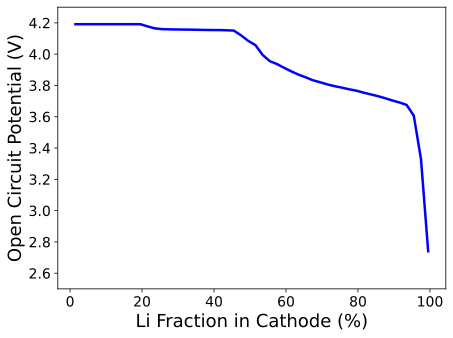

In [8]:
plt.figure()
plt.plot(100 * X_Li_ca, E_cell_kin, color="b", linewidth=2.5)
plt.ylim([2.5, 4.3])
plt.xlabel("Li Fraction in Cathode (%)", fontsize=18)
plt.ylabel("Open Circuit Potential (V)", fontsize=18)

ax = plt.gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)

### Thermodynamic Equilibrium Calculation
For the $i_{app} = 0$ case, we can also calcualte the voltage using thermodynamics.  At equilibrium, the net electrochemical potential change of the reaction must be zero:

\begin{equation}
\sum_k\nu_k\tilde{\mu}_k = 0
\end{equation}

where $\tilde{\mu}_k = \mu_k + z_kF\Phi_k$, where, in turn $\mu_k = \frac{\partial g_k}{\partial n_k}$ is the chemical potential, $\nu_k$ the net stoichiometric coefficient, $z_k$ the net elementary charge, and $\Phi_k$ the phase electric potential for species $k$.

From this, we can calculate the equilibrium electric potential difference $\Delta \Phi_{\rm eq} = \left(\Phi_{\rm elde} - \Phi_{\rm elyte}\right)_{\rm eq}$ as:

\begin{equation}
\Delta \Phi_{\rm eq} = -\frac{\Delta g_{\rm rxn}}{n_{\rm charge}F}
\end{equation}

where $\Delta g_{\rm rxn} = \sum_k \nu_k\mu_k$ is the chemical potential of the reaction and and $n_{\rm charge} = \sum_{k,\,{\rm elde}} \nu_k z_k$ is the net elementary charge transferred from the electrolyte to the electrode.

In [9]:
# Tic
t0 = time.time()

# Initialize array of OCVs:
E_cell_therm = np.zeros_like(X_Li_ca)

for i, X_an in enumerate(X_Li_an):
    # Set anode electrode potential to 0:
    anode.X = "Li[anode]:" + str(X_an) + ", V[anode]:" + str(1 - X_an)
    dG_an = anode_interface.delta_gibbs[0]
    n_charge = -1.0
    E_eq_an = -dG_an / n_charge / ct.faraday

    cathode.X = "Li[cathode]:" + str(1.0 - X_an) + ", V[cathode]:" + str(X_an)
    dG_ca = cathode_interface.delta_gibbs[0]
    n_charge = 1.0
    E_eq_ca = -dG_ca / n_charge / ct.faraday

    E_cell_therm[i] = E_eq_ca - E_eq_an

# Toc
t1 = time.time()
print(f"{i:d} cell voltages calculated in {t1 - t0:3.2e} seconds.")

49 cell voltages calculated in 1.30e-02 seconds.


### Plot thermodynamic OCV, and compare to results from kinetic method

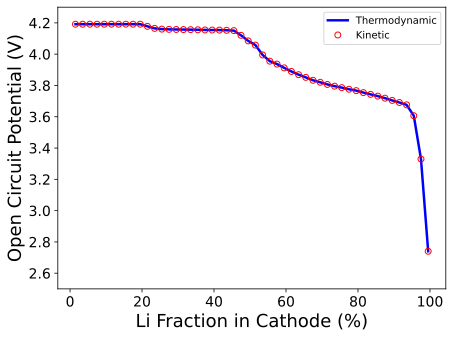

In [10]:
plt.figure()
plt.plot(100 * X_Li_ca, E_cell_therm, color="b", linewidth=2.5)
plt.plot(
    100 * X_Li_ca,
    E_cell_kin,
    linewidth=0.0,
    marker="o",
    markerfacecolor="none",
    markeredgecolor="r",
)
plt.ylim([2.5, 4.3])
plt.xlabel("Li Fraction in Cathode (%)", fontsize=18)
plt.ylabel("Open Circuit Potential (V)", fontsize=18)
plt.legend(["Thermodynamic", "Kinetic"])

ax = plt.gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)

As one would expect, the two approaches give identical results.  While both methods are incredibly fast, the thermodynamic method is roughly 30 times faster.

A large part of this is that the thermodynamic approach is an analytical approach (i.e. the answer is known from theory), while the kinetic approach relies on the root-finding fzero method to fit the correct voltage.  Note also that the kinetic method, because of the use of Butler-Volmer kinetics, calculates the thermodynamic voltage, in order to calculate the overpotential $\eta = \Delta \Phi - \Delta \Phi_{\rm eq}$.

However, it is at last important to note that, while slower, the kinetic method is of course more robust, and can be used to find results away from equilibrium.  The thermodynamic method is only applicable at equilibrium (zero current).